In [1]:
# Load the trained classifier from the file
import joblib
loaded_classifier = joblib.load('trained_classifier.pkl')
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

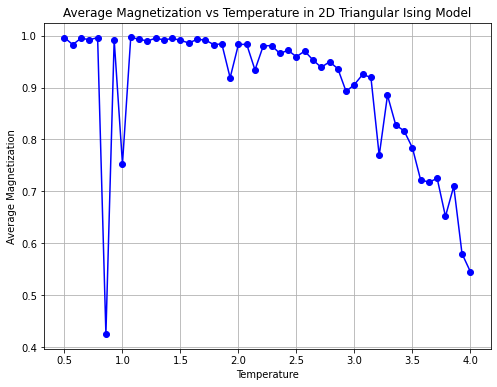

In [2]:
# Data simulation for triangular lattice
def initial_configuration_triangular(size):
    config = np.random.choice([-1, 1], size=(size, size))
    return config
def metropolis_step_triangular(config, beta):
    size = config.shape[0]
    i, j = np.random.randint(size, size=2)
    neighbors = [
        config[(i + 1) % size, j],
        config[(i - 1) % size, j],
        config[i, (j + 1) % size],
        config[i, (j - 1) % size],
        config[(i + 1) % size, (j - 1) % size],
        config[(i - 1) % size, (j + 1) % size],
    ]
    dE = 2 * config[i, j] * np.sum(neighbors)
    if dE < 0 or np.random.rand() < np.exp(-beta * dE):
        config[i, j] *= -1
def monte_carlo_simulation_triangular(size, num_steps, temperature):
    config = initial_configuration_triangular(size)
    beta = 1.0 / temperature
    magnetization_data = []
    for _ in range(num_steps):
        metropolis_step_triangular(config, beta)
        magnetization = abs(np.sum(config))
        magnetization_data.append(magnetization)
    return magnetization_data
# Parameters for triangular lattice
size = 10
num_steps = 49000
temperatures = np.linspace(0.5, 4.0, 50)
all_configurations = []
average_magnetizations_per_spin = []
for temperature in temperatures:
    magnetization_data = monte_carlo_simulation_triangular(size, num_steps, temperature)
    average_magnetization_per_spin = np.mean(magnetization_data) / (size ** 2)
    average_magnetizations_per_spin.append(average_magnetization_per_spin)    
    config = initial_configuration_triangular(size)  # Get the lattice configuration
    config_data = [(temperature,np.copy(config))]  # Create a list to store configurations
    all_configurations.append(config_data)    
    for step in range(num_steps):
        metropolis_step_triangular(config, 1.0 / temperature)
        if step % 1000 == 0:
            config_data.append((temperature,np.copy(config))) 
# Create line graph
plt.figure(figsize=(8, 6))
plt.plot(temperatures, average_magnetizations_per_spin, marker='o', linestyle='-', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Average Magnetization')
plt.title('Average Magnetization vs Temperature in 2D Triangular Ising Model')
plt.grid(True)
plt.show()


In [3]:
# Save the all_configurations array to a CSV file
csv_filename = "ising_model_configuration_triangle.csv"
threshold = 0.5
with open(csv_filename, "w") as csv_file:
    for config_data in all_configurations:
        temperature = config_data[0][0]
        for temperature, config in config_data:
            flattened_config = config.flatten()
            magnetization = abs(np.sum(config)) / config.size  # Calculate and take absolute value of magnetization per spin
            label = "ferromagnetic" if magnetization >= threshold else "paramagnetic"
            
            csv_file.write(f"{temperature},{','.join(map(str, flattened_config))},{label}\n")


print("CSV file saved:", csv_filename)

CSV file saved: ising_model_configuration_triangle.csv


In [4]:
# Define the temperature ranges
temperature_ranges = [(0.5, 1.5), (3.0, 4.0)]
prediction_temp_range = np.linspace(0.5, 4.0, 50)

In [5]:
# Creation of Testing dataset
# Initialize variables to track the phase transition
all_configurations_test = []
# Simulate the Ising model and predict at different temperatures
for temperature in prediction_temp_range:
    # Perform Monte Carlo simulation to obtain a configuration
    num_steps = 49000  # You can adjust the number of steps as needed
    config_2 = initial_configuration_triangular(size)  # Get the lattice configuration
    config_data_2 = [(temperature,np.copy(config_2))]  # Create a list to store configurations
    all_configurations_test.append(config_data_2)    
    for step in range(num_steps):
        metropolis_step_triangular(config_2, 1.0 / temperature)        
        config_data_2.append((temperature,np.copy(config_2))) 

In [6]:
# Initialise variables
configurations_to_predict_combo = []
configurations_to_predict = []
threshold_mag = 0.5
true_labels = []
# Looping through the testing data
for config_data_2 in all_configurations_test:
        temperature = config_data_2[0][0]
        for temperature, config_2 in config_data_2:
            flattened_config_2 = config_2.flatten() 
            magnetization_test = abs(np.sum(config_2)) / config_2.size  # Calculate and take absolute value of magnetization per spin
            labels = 'ferromagnetic' if magnetization_test >= threshold_mag else 'paramagnetic'
            true_labels.append(labels)
            temperature_and_config = (temperature, flattened_config_2)
            configurations_to_predict.append(flattened_config_2)    # Storing the configurations for prediction
            configurations_to_predict_combo.append(temperature_and_config)  # Storing the temperature with the configuration            
# print(len(configurations_to_predict))

In [7]:
# Predict labels using your classifier
predicted_labels = loaded_classifier.predict(configurations_to_predict)
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)
# Create a classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)

Accuracy: 0.9282006489663476
Confusion Matrix:
 [[2064657  137770]
 [  38142  209481]]
Classification Report:
                precision    recall  f1-score   support

ferromagnetic       0.98      0.94      0.96   2202427
 paramagnetic       0.60      0.85      0.70    247623

     accuracy                           0.93   2450050
    macro avg       0.79      0.89      0.83   2450050
 weighted avg       0.94      0.93      0.93   2450050



In [8]:
# Using the classifier model for prediction using function predict_proba
predictions_probs = []
predictions_probs = loaded_classifier.predict_proba(configurations_to_predict) # Gives the probability of being ferromagnetic in nature
# print(predictions_probs)

In [9]:
# Matching the predictions with the temperatures
matched_data = []
for temperature, prediction_prob in zip([item[0] for item in configurations_to_predict_combo], predictions_probs):
    matched_data.append((temperature, prediction_prob))

In [10]:
# Gathering the counts of ferromagnetic nature for each temperature
ferromagnetic_counts = {}  # Initialize a dictionary to store counts
# Iterate through matched data and count "ferromagnetic" predictions
for temperature, prediction_prob in matched_data:
    # Check if the prediction is "ferromagnetic" (assuming "ferromagnetic" is the positive class)
    is_ferromagnetic = prediction_prob.argmax()  # Get the index of the maximum probability
    if is_ferromagnetic == 0:
        # If the prediction is "ferromagnetic," increment the count for the corresponding temperature
        if temperature not in ferromagnetic_counts:
            ferromagnetic_counts[temperature] = 0
        ferromagnetic_counts[temperature] += 1
print(ferromagnetic_counts)


{0.5714285714285714: 48097, 0.6428571428571428: 48638, 0.7142857142857143: 46590, 0.7857142857142857: 48545, 0.8571428571428571: 48216, 0.9285714285714286: 48555, 1.0: 48768, 1.0714285714285714: 47277, 1.1428571428571428: 44199, 1.2142857142857142: 48519, 1.2857142857142856: 47798, 1.3571428571428572: 48554, 1.4285714285714284: 48111, 1.5: 48373, 1.5714285714285714: 48879, 1.6428571428571428: 43603, 1.7142857142857142: 42675, 1.7857142857142856: 48727, 1.857142857142857: 48471, 1.9285714285714284: 47584, 2.0: 47887, 2.071428571428571: 45229, 2.142857142857143: 48675, 2.2142857142857144: 48218, 2.2857142857142856: 47429, 2.3571428571428568: 48278, 2.4285714285714284: 48705, 2.5: 48066, 2.571428571428571: 48106, 2.642857142857143: 46158, 2.714285714285714: 47722, 2.7857142857142856: 47744, 2.857142857142857: 45396, 2.9285714285714284: 47134, 3.0: 46315, 3.071428571428571: 43057, 3.142857142857143: 44655, 3.214285714285714: 43532, 3.2857142857142856: 40167, 3.3571428571428568: 35417, 3.42

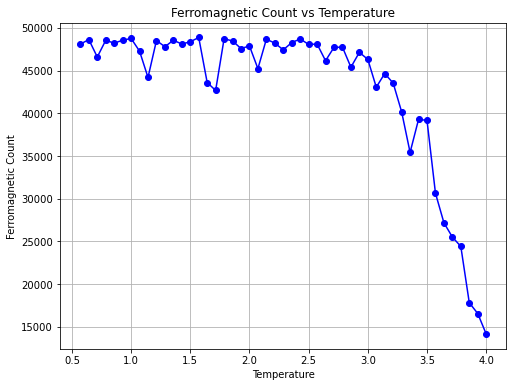

In [11]:
# Plotting a graph for temperature againts the number of ferromagnetic counts
# Extract temperatures and corresponding ferromagnetic counts from the dictionary
temperatures_in_count = list(ferromagnetic_counts.keys())
ferromagnetic_counts_values = list(ferromagnetic_counts.values())
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(temperatures_in_count, ferromagnetic_counts_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Ferromagnetic Count')
plt.title('Ferromagnetic Count vs Temperature')
plt.grid(True)
plt.show()


Potential Critical Temperatures: [3.5, 3.5714, 3.6429, 3.7143, 3.7857]
Critical temperature estimate: 3.6429


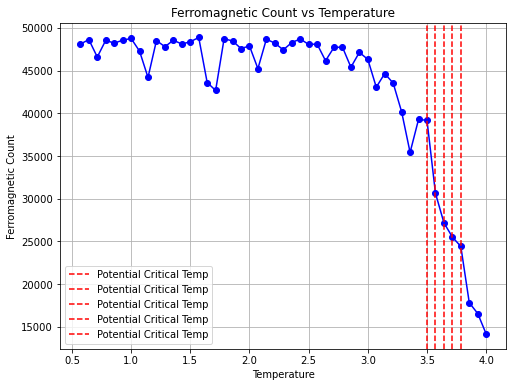

In [16]:
import math
ferromagnetic_count_diffs = []
# Calculate differences in ferromagnetic counts between adjacent temperatures
ferromagnetic_count_diffs = np.diff(ferromagnetic_counts_values)
# Define the threshold for identifying declines 
threshold = 1  
# Define the minimum difference criterion (e.g., 3)
min_difference_criterion = 2  # Adjust as needed
# Initialize variables to track potential critical temperatures
differences_in_intervals = []
temperature_intervals_with_differences = []
# Initialize variables to track the interval with the maximum sum of differences
max_sum_interval = None
max_sum_value = 0
# Iterate through differences in ferromagnetic counts
for i in range(1, len(ferromagnetic_count_diffs)):
    if ferromagnetic_count_diffs[i] < threshold:
        # Identify an interval with decreasing counts
        start_index = max(0, i - 2)  # Consider 2 previous temperatures # Adjust as needed
        end_index = min(i + 3, len(ferromagnetic_count_diffs))  # Ensure end_index does not exceed array size # Adjust as needed
        temperature_interval = temperatures_in_count[start_index:end_index]        
        # Check if the counts are consistently decreasing in the interval
        if all(ferromagnetic_count_diffs[j] < threshold for j in range(start_index, end_index)):            
            interval_differences = ferromagnetic_count_diffs[start_index:end_index]            
# Calculating the sum of differences for each interval in the which are consistently decreasing
            min_difference = abs(sum(interval_differences))
        # Check if this interval has the maximum sum of differences
            if min_difference > max_sum_value:
                max_sum_value = min_difference
                max_sum_interval = interval_differences            
        # Check if the minimum difference within the interval meets the criterion
            if min_difference >= min_difference_criterion:           
                # Store the differences in the intervals
                differences_in_intervals.append(interval_differences)               
               # Store the temperature interval along with differences in the list
                temperature_intervals_with_differences.append((temperature_interval, interval_differences))                
# Finding the index of intervals at which the maximum difference is seen               
max_sum_interval_index = None
max_sum_temperature_interval = None
for idx, interval in enumerate(differences_in_intervals):
    if np.array_equal(interval, max_sum_interval):
        max_sum_interval_index = idx
        break
if max_sum_interval_index is not None:
    max_sum_temperature_interval, _ = temperature_intervals_with_differences[max_sum_interval_index]
# Output potential critical temperatures
max_sum_temperature_interval = list(map(lambda x: round(x, 4), max_sum_temperature_interval))
print("Potential Critical Temperatures:", max_sum_temperature_interval)
length= len(max_sum_temperature_interval)
center_index = (length - 1) // 2  
center_value = max_sum_temperature_interval[center_index]
print("Critical temperature estimate:", center_value)
# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(temperatures_in_count, ferromagnetic_counts_values, marker='o', linestyle='-', color='blue')
plt.xlabel('Temperature')
plt.ylabel('Ferromagnetic Count')
plt.title('Ferromagnetic Count vs Temperature')
plt.grid(True)
# Plot vertical lines or markers for potential critical temperatures
for temp in max_sum_temperature_interval:
    plt.axvline(x=temp, color='red', linestyle='--', label='Potential Critical Temp')
plt.legend()
plt.show()
